In [1]:
import os

os.chdir(os.path.join('..', '..', '..'))
print(os.getcwd())

/Users/eharkin/Documents/projects/5HTGIF


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from scipy.interpolate import UnivariateSpline

from grr.cell_class import Cell
from grr.Trace import getRisingEdges
from grr.Tools import timeToIndex
from ezephys import pltools
from ezephys.pltools import hide_border

In [3]:
DATA_PATH = os.path.join('data', 'raw', '5HT', 'spk_time')
IMG_PATH = os.path.join('figs', 'ims', 'writeup', 'fig1')
NOTEBOOK_PATH = os.path.join('figs', 'scripts', 'writeup')

plt.style.use(os.path.join(NOTEBOOK_PATH, 'publication_figure_style.dms'))

In [4]:
fnames = pd.read_csv(os.path.join(DATA_PATH, 'index.csv'))

# Drop rows with drug treatment.
ctrl_fnames = fnames.loc[(fnames['PE'] == 0) & (fnames['4AP'] == 0), :]

experiments = []
for cell_id in ctrl_fnames['Cell'].unique():
    single_neuron_fnames = ctrl_fnames.loc[
        ctrl_fnames['Cell'] == cell_id, 'Recording'
    ].tolist()
    experiments.append(
        Cell().read_ABF(
            [os.path.join(DATA_PATH, fname) for fname in single_neuron_fnames]
        )
    )

In [5]:
def get_spike_latency(voltage, start_time, threshold=0., refractory_period=3., dt=0.1):
    """Get the time to the first spike after start_time.

    Returns NaN if there are no spikes after start_time, or if there are any
    spikes before start_time.

    Arguments
    ---------
    voltage : 1d float array-like
    start_time : float
    threshold : float, default 0.
        Voltage threshold for spike detection.
    refractory_period: float, default 3.
        Absolute refractory period for spike detection. Avoids detecting the
        same spike multiple times due to noise.
    dt : float, default 0.1
        Timestep of recording (ms).

    Returns
    -------
    float time from start_time until first spike (if any).

    """
    spike_inds = getRisingEdges(voltage, threshold, refractory_period)
    spike_times = spike_inds * dt

    if np.any(spike_times <= start_time):
        latency = np.nan
    elif not np.any(spike_times > start_time):
        latency = np.nan
    else:
        latency = np.min(spike_times - start_time)

    return latency

In [6]:
latency_extraction_params = {
    'V_pre_slice': slice(timeToIndex(2495.0, 0.1)[0], timeToIndex(2595.0, 0.1)[0]),
    'I_step_slice': slice(timeToIndex(2647.0, 0.1)[0], timeToIndex(2747.0, 0.1)[0]),
    'baseline_slice': slice(timeToIndex(0, 0.1)[0], timeToIndex(100., 0.1)[0]),
    'step_start_time': 2647.0,
}
latency_data = {'latency': [], 'voltage': [], 'current': []}
for expt in experiments:
    single_expt_latency = {'latency': [], 'voltage': [], 'current': []}
    for rec in expt:
        single_expt_latency['current'].append(
            (
                np.mean(rec[1, latency_extraction_params['I_step_slice'], :])
                - np.mean(rec[1, latency_extraction_params['baseline_slice'], :])
            )
        )
        for sweep in range(rec.shape[2]):
            single_expt_latency['latency'].append(
                get_spike_latency(
                    rec[0, :, sweep],
                    latency_extraction_params['step_start_time'],
                )
            )
            single_expt_latency['voltage'].append(
                np.mean(
                    rec[0, latency_extraction_params['V_pre_slice'], sweep]
                )
            )
    for key in latency_data:
        latency_data[key].append(np.array(single_expt_latency[key]))

del single_expt_latency

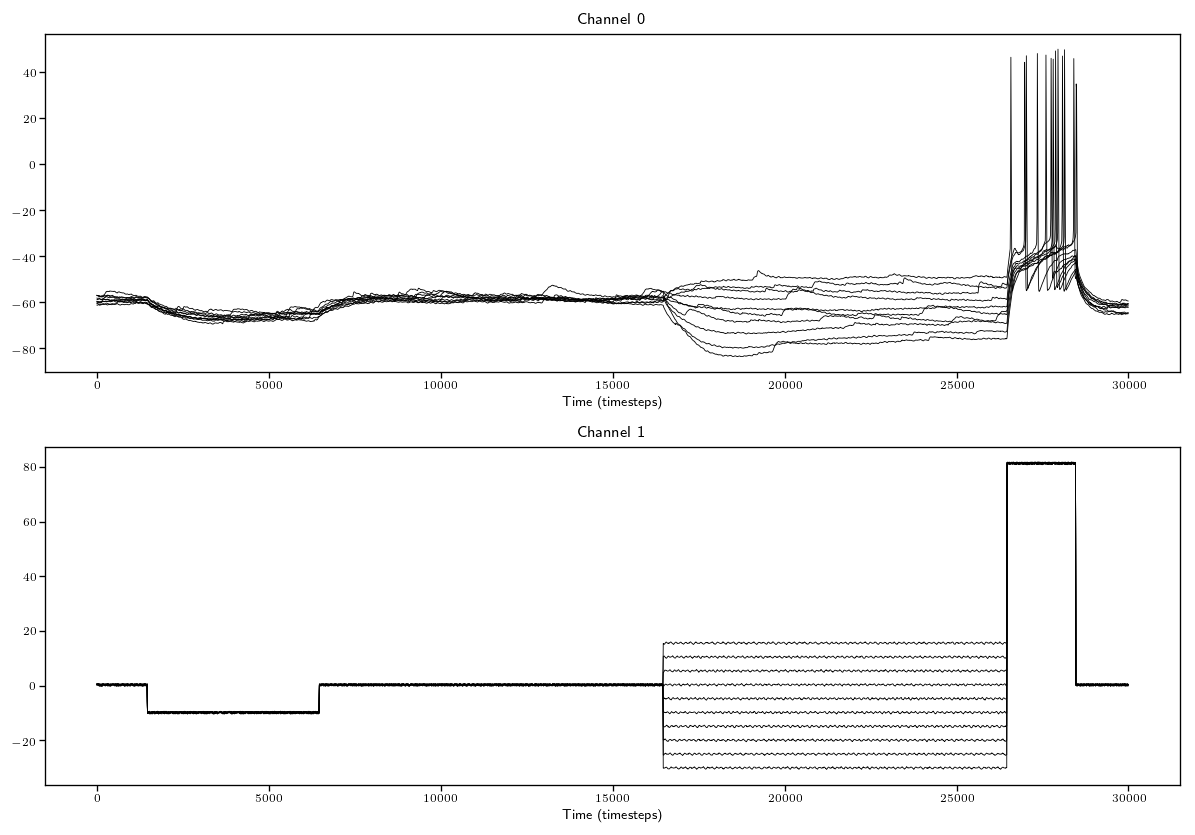

In [7]:
experiments[0][0].plot()

In [8]:
stimulus_current = np.array(latency_data['current'])
stimulus_current

array([[81.08897095, 81.08834839, 81.09122314, 81.09090576, 81.09140015],
       [81.1098999 , 81.11409302, 81.11491699, 81.11046143, 81.10858765],
       [60.81027222, 60.80921631, 60.80975952, 60.80996704, 60.812854  ],
       [60.80554199, 60.81083984, 60.80690918, 60.80595703, 60.80806274],
       [60.79869995, 60.80201416, 60.80188599, 60.803479  , 60.79522095],
       [60.86242065, 60.86432495, 60.8638855 , 60.86325684, 60.86157227],
       [40.55805664, 40.55576782, 40.55615845, 40.55496216, 40.55324707],
       [40.71760254, 40.7173645 , 40.72047729, 40.72081299, 40.71875   ]])

In [9]:
stimulus_current_mean = stimulus_current.mean(axis=1)
stimulus_current_mean

array([81.09016968, 81.1115918 , 60.81041382, 60.80746216, 60.80026001,
       60.86309204, 40.55563843, 40.71900146])

In [10]:
stimulus_current_norm = (stimulus_current_mean - stimulus_current_mean.min())
stimulus_current_norm /= stimulus_current_norm.max()

In [11]:
plt.cm.viridis(stimulus_current_norm)

array([[0.993248, 0.906157, 0.143936, 1.      ],
       [0.993248, 0.906157, 0.143936, 1.      ],
       [0.128729, 0.563265, 0.551229, 1.      ],
       [0.128729, 0.563265, 0.551229, 1.      ],
       [0.128729, 0.563265, 0.551229, 1.      ],
       [0.127568, 0.566949, 0.550556, 1.      ],
       [0.267004, 0.004874, 0.329415, 1.      ],
       [0.26851 , 0.009605, 0.335427, 1.      ]])

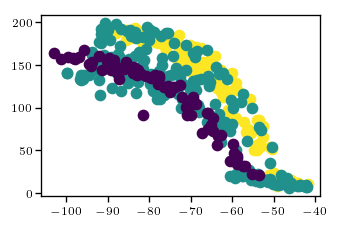

In [12]:
for latencies, voltages, current in zip(latency_data['latency'], latency_data['voltage'], stimulus_current_norm):
    plt.plot(voltages, latencies, 'o', color=plt.cm.viridis(current))

Colors indicate different current injections.

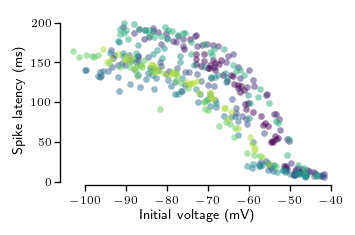

In [13]:
for i, (latencies, voltages) in enumerate(zip(latency_data['latency'], latency_data['voltage'])):
    plt.plot(
        voltages, 
        latencies, 
        'o',
        alpha=0.5,
        color=plt.cm.viridis(float(i)/len(latency_data['latency'])),
        markeredgecolor='none',
        markersize=4
    )

plt.xlabel('Initial voltage (mV)')
plt.ylabel('Spike latency (ms)')
hide_border('tr', trim=True)

plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'ser_latency_steps.png'))

Colors indicate different cells.

# Splines

Too wiggly.

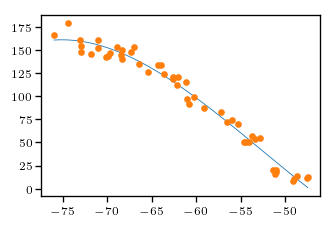

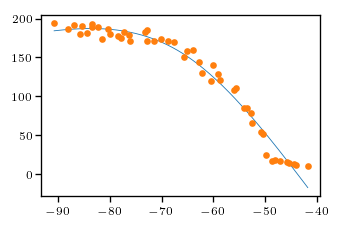

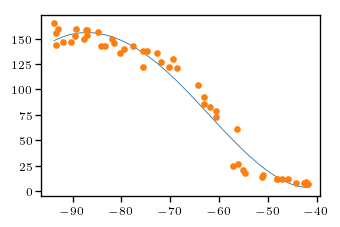

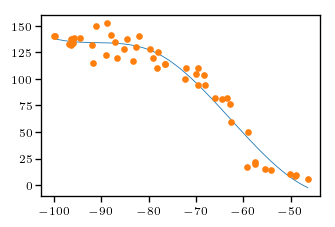

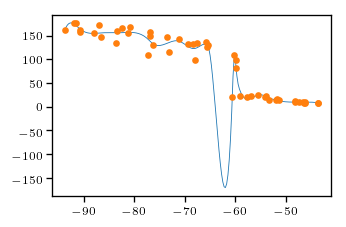

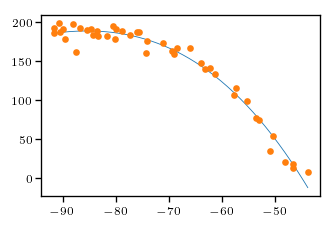

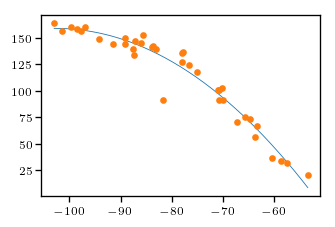

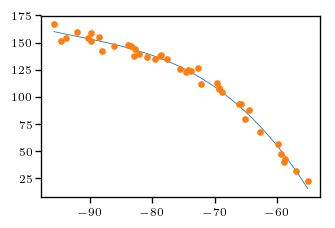

In [14]:
for latencies, voltages in zip(latency_data['latency'], latency_data['voltage']):
    inds = np.argsort(voltages)
    voltages_sorted = voltages[inds]
    latencies_sorted = latencies[inds]
    
    spl = UnivariateSpline(
        voltages_sorted[~np.isnan(latencies_sorted)], 
        latencies_sorted[~np.isnan(latencies_sorted)], 
        s=5e3
    )
    x = np.linspace(np.nanmin(voltages_sorted[~np.isnan(latencies_sorted)]), np.nanmax(voltages_sorted[~np.isnan(latencies_sorted)]), 200)
    
    plt.figure()
    plt.plot(x, spl(x))
    plt.plot(voltages_sorted, latencies_sorted, '.')
    plt.show()

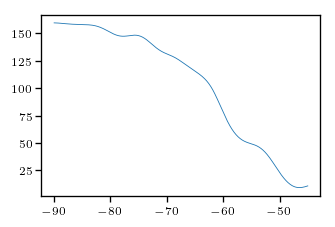

In [15]:
all_latencies = np.concatenate(latency_data['latency'])
all_voltages = np.concatenate(latency_data['voltage'])

inds = np.argsort(all_voltages)
all_voltages_sorted = all_voltages[inds]
all_latencies_sorted = all_latencies[inds]

spl = UnivariateSpline(
    all_voltages_sorted[~np.isnan(all_latencies_sorted)], 
    all_latencies_sorted[~np.isnan(all_latencies_sorted)],
    k=4,
    s=2.35e5
)

x = np.linspace(-90, -45, 500)
plt.plot(x, spl(x))

# Pharmacology

In [16]:
pharmacology_fnames = {
    'baseline': ['18627043.abf', '18627044.abf', '18627045.abf', '18627046.abf', '18627047.abf'],
    '4AP': ['18627053.abf', '18627054.abf', '18627055.abf'],
    #'wash': ['18627062.abf', '18627063.abf', '18627064.abf']
}
pharmacology_recs = {
    cond: Cell().read_ABF(
        [os.path.join(DATA_PATH, fname) for fname in pharmacology_fnames[cond]]
    ) for cond in pharmacology_fnames
}

/miniconda3/envs/neopozz/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


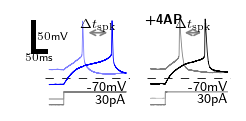

In [17]:
spec_4AP = gs.GridSpec(2, 2, height_ratios = [1, 0.2], hspace = 0.1)

plt.figure(figsize = (2, 1))

### B: real neurons

trace_time_slice = slice(25400, 28400)
t_vec = np.arange(0, 300, 0.1)
V_ax_bl = plt.subplot(spec_4AP[0, 0])
#plt.title(' 5HT neuron', loc = 'left')
plt.axhline(-70, color = 'k', ls = '--', lw = 0.5, dashes = (10, 10))
plt.annotate('-70mV', (300, -72), ha = 'right', va = 'top')
plt.annotate('', (140, 9), (240, 9), arrowprops = {'arrowstyle': '<->'})
plt.text(190, 14, '$\\Delta t_\\mathrm{{spk}}$', ha = 'center')
plt.ylim(-85, 40)

I_ax_bl = plt.subplot(spec_4AP[1, 0])
plt.annotate('30pA', (300, 28), ha = 'right', va = 'top')
pltools.hide_border()
pltools.hide_ticks()

for i, sweep_no in enumerate([3, 8]):
    V_ax_bl.plot(
        t_vec, pharmacology_recs['baseline'][0][0, trace_time_slice, sweep_no],
        'b-', lw = 0.5, alpha = 1./(i + 1)
    )
    I_ax_bl.plot(
        t_vec, pharmacology_recs['baseline'][0][1, trace_time_slice, sweep_no],
        color = 'gray', lw = 0.5, alpha = 1./(i + 1)
    )

pltools.add_scalebar(
    y_units = 'mV', x_units = 'ms', anchor = (-0.15, 0.5),
    y_label_space = (-0.05), x_on_left = False, x_size = 50,
    bar_space = 0, ax = V_ax_bl
)

V_ax_4AP = plt.subplot(spec_4AP[0, 1])
#plt.title('$I_A$ blocked', loc = 'left')
plt.axhline(-70, color = 'k', ls = '--', lw = 0.5, dashes = (10, 10))
plt.annotate('-70mV', (300, -72), ha = 'right', va = 'top')
plt.annotate('\\textbf{{+4AP}}', (50, 25), ha = 'center')
plt.annotate('', (120, 9), (210, 9), arrowprops = {'arrowstyle': '<->'})
plt.text(165, 14, '$\\Delta t_\\mathrm{{spk}}$', ha = 'center')
plt.ylim(-85, 40)

I_ax_4AP = plt.subplot(spec_4AP[1, 1])
plt.annotate('30pA', (300, 28), ha = 'right', va = 'top')

for i, sweep_no in enumerate([4, 11]):
    V_ax_4AP.plot(
        t_vec, pharmacology_recs['4AP'][0][0, trace_time_slice, sweep_no],
        'k-', lw = 0.5, alpha = 1./(i + 1)
    )
    I_ax_4AP.plot(
        t_vec, pharmacology_recs['4AP'][0][1, trace_time_slice, sweep_no],
        color = 'gray', lw = 0.5, alpha = 1./(i + 1)
    )

pltools.hide_border(ax = V_ax_4AP)
pltools.hide_ticks(ax = V_ax_4AP)
pltools.hide_border(ax = I_ax_4AP)
pltools.hide_ticks(ax = I_ax_4AP)

plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'pharmacology_sample_traces.png'))

In [18]:
latency_extraction_params = {
    'V_pre_slice': slice(timeToIndex(2495.0, 0.1)[0], timeToIndex(2595.0, 0.1)[0]),
    'I_step_slice': slice(timeToIndex(2647.0, 0.1)[0], timeToIndex(2747.0, 0.1)[0]),
    'baseline_slice': slice(timeToIndex(0, 0.1)[0], timeToIndex(100., 0.1)[0]),
    'step_start_time': 2647.0,
}
pharmacology_latencies = {
    condition: {'latency': [], 'voltage': [], 'current': []} for condition in pharmacology_recs
}
for condition in pharmacology_recs:
    single_expt_latency = {'latency': [], 'voltage': [], 'current': []}
    for rec in pharmacology_recs[condition]:
        single_expt_latency['current'].append(
            (
                np.mean(rec[1, latency_extraction_params['I_step_slice'], :])
                - np.mean(rec[1, latency_extraction_params['baseline_slice'], :])
            )
        )
        for sweep in range(rec.shape[2]):
            single_expt_latency['latency'].append(
                get_spike_latency(
                    rec[0, :, sweep],
                    latency_extraction_params['step_start_time'],
                )
            )
            single_expt_latency['voltage'].append(
                np.mean(
                    rec[0, latency_extraction_params['V_pre_slice'], sweep]
                )
            )
    for key in latency_data:
        pharmacology_latencies[condition][key].append(np.array(single_expt_latency[key]))

del single_expt_latency

In [19]:
print(pharmacology_latencies['baseline']['current'])
print(pharmacology_latencies['4AP']['current'])

[array([40.71760254, 40.7173645 , 40.72047729, 40.72081299, 40.71875   ])]
[array([40.72170149, 40.72194999, 40.72413417])]


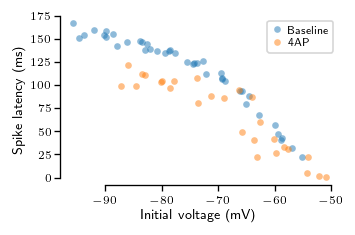

In [20]:
plt.plot(
    np.asarray(pharmacology_latencies['baseline']['voltage']).flatten(), 
    np.asarray(pharmacology_latencies['baseline']['latency']).flatten(), 
    'o',
    alpha=0.5,
    markeredgecolor='none',
    markersize=4,
    label='Baseline'
)
plt.plot(
    np.asarray(pharmacology_latencies['4AP']['voltage']).flatten(), 
    np.asarray(pharmacology_latencies['4AP']['latency']).flatten(), 
    'o',
    alpha=0.5,
    markeredgecolor='none',
    markersize=4,
    label='4AP'
)
plt.legend()
hide_border('tr', trim=True)
plt.xlabel('Initial voltage (mV)')
plt.ylabel('Spike latency (ms)')

plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'pharmacology_latency.png'))
    
plt.show()